# When to buy Prediction  with XGBoost and SMOTE-ENN


- Let's use major supervised learning algorithm and compare the results.
  - Logistic regression
  - KNN
  - SVM
  - Decision Tree
  - Random Forest
  - AdaBoost
  - XGBoost
- The data is imbalanced, so apply rebalancing methods and compare their results  with those of baseline models.
  - Baseline models: Imbalanced data
  - SMOTE
  - SMOTE-ENN
- Performance measure
  - Accuracy
  - Recall
  - F1 score
  - AUC score

In [1]:

# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
from pandas import Timestamp
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#plt.style.use('seaborn-talk')
#plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
#import missingno as msno
#from google.colab import drive
#import pymc3 as pm
#from theano import shared, theano as tt

In [12]:
# Lớp này chứa các hàm tĩnh để hỗ trợ đa xử lý
class MultiProcessing:

    # Hàm khởi tạo trống
    def __init__(self):
        pass

    @staticmethod
    def lin_parts(num_atoms, num_threads):
        """
        Hàm này phân chia danh sách các atom thành các tập con (phân tử) có kích thước bằng nhau.
        Một atom là một tập hợp các tác vụ không thể chia nhỏ hơn.
        """
        # Phân chia các atom bằng một vòng lặp duy nhất
        parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
        parts = np.ceil(parts).astype(int)
        return parts

    @staticmethod
    def nested_parts(num_atoms, num_threads, upper_triangle=False):
        """
        Hàm này cho phép song song hóa các vòng lặp lồng nhau.
        """
        # Phân chia các atom với một vòng lặp bên trong
        parts = []
        num_threads_ = min(num_threads, num_atoms)
        for num in range(num_threads_):
            part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
            part = (-1 + part ** .5) / 2.
            parts.append(part)
        parts = np.round(parts).astype(int)
        if upper_triangle:  # các hàng đầu tiên nặng nhất
            parts = np.cumsum(np.diff(parts)[::-1])
            parts = np.append(np.array([0]), parts)
        return parts

    @staticmethod
    def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
        """
        :param func: (string) hàm cần được song song hóa
        :param pd_obj: (vector) Phần tử 0 là tên của đối số dùng để truyền phân tử;
                                Phần tử 1 là danh sách các atom cần được nhóm thành một phân tử
        :param num_threads: (int) số lượng luồng
        :param mp_batches: (int) số lượng batch
        :param lin_mols: (bool) Cho biết phương thức nên sử dụng phân vùng tuyến tính hay lồng nhau
        :param kargs: (var args) các đối số bổ sung
        :return: (data frame) kết quả
        """
  
    
        # Kiểm tra nếu sử dụng phân vùng tuyến tính
        if lin_mols:
            # Sử dụng phân vùng tuyến tính
            parts = MultiProcessing.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
        else:
            # Sử dụng phân vùng lồng nhau
            parts = MultiProcessing.nested_parts(len(pd_obj[1]), num_threads * mp_batches)
        
        # Khởi tạo danh sách công việc
        jobs = []
        # Tạo các công việc dựa trên phân vùng
        for i in range(1, len(parts)):
            job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
            job.update(kargs)
            jobs.append(job)
        
        # Xử lý công việc dựa trên số lượng luồng
        if num_threads == 1:
            # Xử lý tuần tự nếu chỉ có 1 luồng
            out = MultiProcessing.process_jobs_(jobs)
        else:
            # Xử lý song song nếu có nhiều luồng
            out = MultiProcessing.process_jobs(jobs, num_threads=num_threads)
        
        # Xử lý kết quả đầu ra
        if isinstance(out[0], pd.DataFrame):
            df0 = pd.DataFrame()
        elif isinstance(out[0], pd.Series):
            df0 = pd.Series()
        else:
            return out
        
        # Gộp kết quả
        for i in out:
            df0 = pd.concat([df0, i])
            #df0 = df0.append(i)
        df0 = df0.sort_index()
        return df0
    
    @staticmethod
    def process_jobs_(jobs):
        """ Chạy các công việc tuần tự, để debug """
        out = []
        for job in jobs:
            out_ = MultiProcessing.expand_call(job)
            out.append(out_)
        return out
    
    @staticmethod
    def expand_call(kargs):
        """ Mở rộng các đối số của hàm callback, kargs['func'] """
        func = kargs['func']
        del kargs['func']
        out = func(**kargs)
        return out
    
    @staticmethod
    def report_progress(job_num, num_jobs, time0, task):
        # Báo cáo tiến độ khi các công việc bất đồng bộ hoàn thành
        msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
        msg.append(msg[1] * (1/msg[0] - 1))
        time_stamp = str(dt.datetime.fromtimestamp(time.time()))
        msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
            str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'
        if job_num < num_jobs:
            sys.stderr.write(msg+'\r')
        else:
            sys.stderr.write(msg+'\n')
        return
    
    @staticmethod
    def process_jobs(jobs, task=None, num_threads=24):
        """ Chạy song song. jobs phải chứa một callback 'func' cho expand_call"""
        if task is None:
            task = jobs[0]['func'].__name__
        # Tạo pool với số lượng luồng chỉ định
        pool = mp.Pool(processes=num_threads)
        # Sử dụng imap_unordered để xử lý công việc bất đồng bộ
        outputs = pool.imap_unordered(MultiProcessing.expand_call, jobs)
        out = []
        time0 = time.time()
        # Xử lý đầu ra bất đồng bộ, báo cáo tiến độ
        for i, out_ in enumerate(outputs, 1):
            out.append(out_)
            MultiProcessing.report_progress(i, len(jobs), time0, task)
        pool.close()
        pool.join()  # Cần thiết để ngăn rò rỉ bộ nhớ
        return out

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Load and Explore Dataset

In [14]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

#from sklearn.metrics import roc_auc_score,roc_curve,scorer

In [15]:
def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Giá đóng cửa
    :param lookback: (int) khoảng thời gian nhìn lại để tính biến động
    :return: (series) giá trị biến động hàng ngày
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    # Tìm vị trí của các ngày trước đó trong index
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    
 
    df0 = df0[df0 > 0]
    
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:], name='value'))
    df0
    
    # Chuyển đổi thành DataFrame và đặt tên cột là 'value'
    df1 = df0.to_frame()
    close_today=close.loc[df0.index]
        
    close_yesterday=data.loc[df1['value']]['close']
    close_yesterday
    
    # Thêm các cột close_today và close_yesterday vào DataFrame df1
    df1['close_today'] = close_today.values
    df1['close_yesterday'] = close_yesterday.values
    
    # Tính tỷ lệ phần trăm thay đổi giá hàng ngày (daily returns)
    daily_returns = (df1['close_today'] / df1['close_yesterday'] - 1).rename("return")
    daily_vol = daily_returns.ewm(span=lookback).std()
    

    
    return daily_vol

In [16]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) chuỗi giá đóng cửa.
    :param threshold: (float) khi giá trị tuyệt đối của sự thay đổi lớn hơn ngưỡng này, 
    hàm sẽ ghi nhận nó như một sự kiện.
    :return: (datetime index vector) vector các mốc thời gian khi sự kiện xảy ra. Được sử dụng sau này để lấy mẫu.
    """
    print('Applying Symmetric CUSUM filter.')
    
    # Khởi tạo danh sách để lưu các sự kiện
    t_events = []
    
    # Khởi tạo biến tích lũy cho giá trị dương và âm
    s_pos = 0
    s_neg = 0
    
    # Tính logarit của tỷ lệ thay đổi giá
    diff = np.log(raw_price).diff().dropna()
    
    # Duyệt qua từng mốc thời gian trong chuỗi giá
    for i in tqdm(diff.index[1:]):
        # Cập nhật giá trị tích lũy dương và âm
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        
        # Giới hạn giá trị tích lũy dương không nhỏ hơn 0
        s_pos = max(0.0, pos)
        # Giới hạn giá trị tích lũy âm không lớn hơn 0
        s_neg = min(0.0, neg)
        
        # Kiểm tra nếu giá trị tích lũy âm vượt ngưỡng
        if s_neg < -threshold:
            s_neg = 0  # Reset giá trị tích lũy âm
            t_events.append(i)  # Ghi nhận sự kiện
        # Kiểm tra nếu giá trị tích lũy dương vượt ngưỡng
        elif s_pos > threshold:
            s_pos = 0  # Reset giá trị tích lũy dương
            t_events.append(i)  # Ghi nhận sự kiện
    
    # Chuyển đổi danh sách sự kiện thành DatetimeIndex
    event_timestamps = pd.DatetimeIndex(t_events)
    
    return event_timestamps

In [17]:
def bbands(close_prices, window, no_of_stdev):
    # Hàm tính toán Bollinger Bands

    # Tính trung bình động theo phương pháp EMA (Exponential Moving Average)
    rolling_mean = close_prices.ewm(span=window).mean()
    
    # Tính độ lệch chuẩn động theo phương pháp EMA
    rolling_std = close_prices.ewm(span=window).std()
    
    # Tính dải trên của Bollinger Bands
    # Bằng trung bình động cộng với (độ lệch chuẩn * số lần độ lệch chuẩn)
    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    
    # Tính dải dưới của Bollinger Bands
    # Bằng trung bình động trừ đi (độ lệch chuẩn * số lần độ lệch chuẩn)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)
    
    # Trả về trung bình động, dải trên và dải dưới
    return rolling_mean, upper_band, lower_band

In [18]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) chuỗi các sự kiện (từ bộ lọc CUSUM đối xứng)
    :param close: (series) giá đóng cửa
    :param num_days: (int) số ngày tối đa mà một giao dịch có thể hoạt động
    :return: (series) mốc thời gian của các rào cản dọc
    """
    # Tìm vị trí của các ngày kết thúc (num_days sau mỗi sự kiện) trong index của close
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    
    # Loại bỏ các vị trí vượt quá độ dài của chuỗi close
    t1 = t1[t1 < close.shape[0]]
    
    # Tạo Series mới với index là t_events và giá trị là ngày kết thúc tương ứng
    # NaN sẽ xuất hiện ở cuối nếu có sự kiện không có ngày kết thúc tương ứng
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    
    return t1

In [19]:
def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) giá đóng cửa
    :param events: (series) các chỉ số biểu thị "sự kiện"
    :param pt_sl: (array) phần tử 0 chỉ mức chốt lời; phần tử 1 là mức dừng lỗ
    :param molecule: (một mảng) tập các giá trị chỉ mục datetime để xử lý
    :return: (dataframe) mốc thời gian tại đó mỗi rào cản được chạm đến
    """
    # Áp dụng dừng lỗ/chốt lời, nếu nó xảy ra trước t1 (kết thúc sự kiện)
    events_ = events.loc[molecule]
    
    # Tạo bản sao sâu của cột 't1' từ events_
    out = events_[['t1']].copy(deep=True)
    
    # Xác định mức chốt lời
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs
    
    # Xác định mức dừng lỗ
    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs
    
    # Lặp qua từng sự kiện
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # Giá theo đường đi
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # Lợi nhuận theo đường đi
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # Thời điểm dừng lỗ sớm nhất
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # Thời điểm chốt lời sớm nhất
    
    return out

In [20]:
def get_events(close, t_events, pt_sl, target, min_ret, num_threads,
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Giá đóng cửa
    :param t_events: (series) các sự kiện t. Đây là các mốc thời gian sẽ tạo ra mỗi rào cản ba chiều.
    :param pt_sl: (mảng 2 phần tử) phần tử 0 chỉ mức chốt lời; phần tử 1 là mức dừng lỗ.
                  Một số thực không âm xác định độ rộng của hai rào cản.
                  Giá trị 0 có nghĩa là rào cản ngang tương ứng sẽ bị vô hiệu hóa.
    :param target: (series) các giá trị được sử dụng (kết hợp với pt_sl) để xác định độ rộng của rào cản.
    :param min_ret: (float) Lợi nhuận mục tiêu tối thiểu cần thiết để chạy tìm kiếm rào cản ba chiều.
    :param num_threads: (int) Số lượng luồng được sử dụng đồng thời bởi hàm.
    :param vertical_barrier_times: (series) Series pandas với các mốc thời gian của các rào cản dọc.
    :param side: (series) Phía của cược (long/short) được quyết định bởi mô hình chính
    :return: (data frame) của các sự kiện
            -events.index là thời gian bắt đầu sự kiện
            -events['t1'] là thời gian kết thúc sự kiện
            -events['trgt'] là mục tiêu của sự kiện
            -events['side'] (tùy chọn) ngụ ý phía vị thế của thuật toán
    """
    # 1) Lấy mục tiêu
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # Áp dụng min_ret
    target.head()
    # 2) Lấy rào cản dọc (thời gian nắm giữ tối đa)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Tạo đối tượng sự kiện, áp dụng dừng lỗ trên rào cản dọc
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    # Tạo DataFrame events
    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])
    
    # Áp dụng Rào cản Ba chiều
    df0 = MultiProcessing.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    # Cập nhật thời gian kết thúc sự kiện
    events = events.dropna(subset=['t1'])
    #events['t1'] = df0.dropna(how='all').min(axis=1) 
    #events['t1'] = df0.dropna(how='all').apply(lambda x: x.min(), axis=1)
    #events['t1'] = df0.dropna(how='all').astype(int64).min(axis=1)
    #events['t1'] = df0.dropna(how='all').astype(np.int64).min(axis=1)
   # events['t1'] = df0.dropna(how='all').apply(lambda x: x.min().astype('int64'), axis=1)
    #events['t1'] = df0.dropna(how='all').apply(lambda x: x.min().astype(np.int64) if not x.isnull().all() else pd.NaT, axis=1)

    # Loại bỏ cột 'side' nếu không được cung cấp
    if side is None:
        events = events.drop('side', axis=1)

    return events

In [21]:
def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index là thời gian bắt đầu sự kiện
                -events['t1'] là thời gian kết thúc sự kiện
                -events['trgt'] là mục tiêu của sự kiện
                -events['side'] (tùy chọn) ngụ ý phía vị thế của thuật toán
                Trường hợp 1: ('side' không có trong events): bin trong (-1,1) <- gán nhãn bởi hành động giá
                Trường hợp 2: ('side' có trong events): bin trong (0,1) <- gán nhãn bởi lợi nhuận (meta-labeling)
    :param close: (series) giá đóng cửa
    :return: (data frame) của các sự kiện đã được gán nhãn meta
    """
    events_ = triple_barrier_events.dropna(subset=['t1'])  # Loại bỏ các sự kiện không có thời gian kết thúc
    price = events_.copy()  # Sao chép triple_barrier_events

  
    final_price = data.loc[events_['t1']]['close']  
# Thêm cột close_values vào price từ triple_barrier_events
    price['final_price'] = final_price.values
    initial_price=data.loc[events_.index]['close']
    # In ra một số dòng đầu của dataframe price để kiểm tra
    price['initial_price'] = initial_price.values


# 2) Tạo DataFrame đầu ra
    out_df = pd.DataFrame(index=events_.index)
    # Cần tính log returns, nếu không kết quả sẽ bị lệch cho các vị thế short
    #out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['ret']=np.log( price['final_price'])-np.log( price['initial_price'])
    out_df['trgt'] = events_['trgt']
   
     # Loại bỏ các sự kiện không có return
    
    # Meta labeling: Các sự kiện đúng sẽ có lợi nhuận dương
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling
    
    # Thêm code: gán nhãn 0 khi rào cản dọc được chạm đến
    out_df = barrier_touched(out_df)
    
    # Meta labeling: gán nhãn 0 cho các sự kiện không chính xác
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Chuyển đổi log returns trở lại thành returns thông thường
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    
    # Thêm 'side' vào output. Điều này hữu ích khi cần fit một mô hình meta label
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
    out_df=out_df.dropna(subset=['ret']) 
    return out_df

In [22]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) chứa lợi nhuận và mục tiêu
    :return: (DataFrame) chứa lợi nhuận, mục tiêu và nhãn
    """
    # Khởi tạo list để lưu trữ kết quả
    store = []
    
    # Lặp qua từng hàng trong DataFrame
    for i in np.arange(len(out_df)):
        # Lấy thời gian của hàng hiện tại
        date_time = out_df.index[i]
        
        # Lấy giá trị lợi nhuận của hàng hiện tại
        ret = out_df.loc[date_time, 'ret']
        
        # Lấy giá trị mục tiêu của hàng hiện tại
        target = out_df.loc[date_time, 'trgt']
        
        # Kiểm tra nếu rào cản trên được chạm đến
        if ret > 0.0 and ret > target:
            # Rào cản trên được chạm đến
            store.append(1)
        # Kiểm tra nếu rào cản dưới được chạm đến
        elif ret < 0.0 and ret < -target:
            # Rào cản dưới được chạm đến
            store.append(-1)
        else:
            # Rào cản dọc được chạm đến (hoặc không rào cản nào được chạm đến)
            store.append(0)
    
    # Thêm cột 'bin' vào DataFrame với các giá trị đã lưu trữ
    out_df['bin'] = store
    
    # Trả về DataFrame đã được cập nhật
    return out_df

# 2. Data preprocessing

In [23]:
import pandas as pd

data=pd.read_csv('D:/Trading code/Wdata/15m/BTCUSD_Candlestick_15_M_ASK_05.08.2019-29.04.2022.csv')
data.columns = data.columns.str.lower()
#data = data.drop(columns=['open', 'high','low', 'adj close', 'volume'])
data = data[data['volume'] != 0]
data = data.drop(columns=['open', 'high','low',  'volume'])
data['datetime'] = pd.to_datetime(data['datetime'], format="%d.%m.%Y %H:%M:%S.%f")


#data['datetime'] = pd.to_datetime(data['datetime'])
print(data['datetime'].dtype)
data = data.set_index('datetime')
#data = data.set_index('datetime').drop_duplicates()
data.info()



datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84591 entries, 2019-08-05 00:00:00 to 2022-04-29 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   84591 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


In [24]:
# compute bands
window = 20
data['avg'], data['upper'], data['lower'] = bbands(data['close'],window, no_of_stdev=1.5)

# compute sides
data['side'] = np.nan
long_signals = (data['close'] <= data['lower'])
short_signals = (data['close'] >= data['upper'])
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

# Drop the NaN values from our data set
#data.dropna(axis=0, how='any', inplace=True)


side
 1.0    3471
-1.0    3371
Name: count, dtype: int64


In [25]:
close = data['close']

# determining timestamps of first touch
# determining daily volatility using the last 50 days
# creating our event triggers using the CUSUM filter
daily_vol = get_daily_vol(close=close, lookback=50)
cusum_events = get_t_events(close, threshold=daily_vol.mean()*0.1)

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=0.5)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|█████████████████████████████████████████████████████████████████████████| 84589/84589 [00:02<00:00, 29097.42it/s]


In [26]:


pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 0.05%

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

In [27]:
labels = get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

side
 1.0    2153
-1.0    2015
Name: count, dtype: int64

In [28]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])
#bin is actual - the correct ones
# setting predicted column to 1
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3187
           1       0.24      1.00      0.38       981

    accuracy                           0.24      4168
   macro avg       0.12      0.50      0.19      4168
weighted avg       0.06      0.24      0.09      4168

Confusion Matrix
[[   0 3187]
 [   0  981]]

Accuracy
0.23536468330134358


## 3. Prediction with Imbalanced Data: Baseline models

In [29]:
# Get features at event dates
X = data.loc[labels.index, :]
y = labels['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## 3.1.Logistic Regression with Imbalanced Data

In [30]:
# Initiate the model
base_lm = LogisticRegression()
# Fit the model
base_lm_model = base_lm.fit(X_train, y_train.ravel())
# Make Predictions
base_lm_pred=base_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_lm_accuracy = accuracy_score(y_test, base_lm_pred)
base_lm_precision = precision_score(y_test, base_lm_pred)
base_lm_recall = recall_score(y_test, base_lm_pred)
base_lm_f1 = 2 * (base_lm_precision * base_lm_recall) / (base_lm_precision + base_lm_recall)

# Calculate AUC score
base_lm_probs = base_lm.predict_proba(X_test)
base_lm_probs = base_lm_probs[:,1]
base_lm_auc = roc_auc_score(y_test, base_lm_probs)

# Display the metrics
print("Logistic Regression: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(base_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(base_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(base_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_lm_pred))

Logistic Regression: Imbalanced Data
 - Accuracy :  0.766
 - Precision:  0.000
 - Recall   :  0.000
 - F1 score :  nan
 - AUC score:  0.470
Confusion Matrix
[[639   0]
 [195   0]]


## 3.2. KNN with Imbalanced Data

In [31]:
# Initiate the model
base_knn = KNeighborsClassifier()
# Fit the model
base_knn_model = base_knn.fit(X_train, y_train.ravel())
# Make Predictions
base_knn_pred=base_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_knn_accuracy = accuracy_score(y_test, base_knn_pred)
base_knn_precision = precision_score(y_test, base_knn_pred)
base_knn_recall = recall_score(y_test, base_knn_pred)
base_knn_f1 = 2 * (base_knn_precision * base_knn_recall) / (base_knn_precision + base_knn_recall)

# Calculate AUC score
base_knn_probs = base_knn.predict_proba(X_test)
base_knn_probs = base_knn_probs[:,1]
base_knn_auc = roc_auc_score(y_test, base_knn_probs)

# Display the metrics
print("KNN Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(base_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(base_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(base_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_knn_pred))

KNN Classifier: Imbalanced Data
 - Accuracy :  0.670
 - Precision:  0.273
 - Recall   :  0.246
 - F1 score :  0.259
 - AUC score:  0.511
Confusion Matrix
[[511 128]
 [147  48]]


### 3.3. SVM with Imbalanced Data

In [32]:
# Initiate the model
base_svc = SVC(kernel='rbf',probability=True)
# Fit the model
base_svc_model = base_svc.fit(X_train, y_train.ravel())
# Make Predictions
base_svc_pred = base_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_svc_accuracy = accuracy_score(y_test, base_svc_pred)
base_svc_precision = precision_score(y_test, base_svc_pred)
base_svc_recall = recall_score(y_test, base_svc_pred)
base_svc_f1 = 2 * (base_svc_precision * base_svc_recall) / (base_svc_precision + base_svc_recall)

# Calculate AUC score
base_svc_probs = base_svc.predict_proba(X_test)
base_svc_probs = base_svc_probs[:,1]
base_svc_auc = roc_auc_score(y_test, base_svc_probs)

# Display the metrics
print("SVM Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(base_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(base_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(base_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_svc_pred))

SVM Classifier: Imbalanced Data
 - Accuracy :  0.766
 - Precision:  0.000
 - Recall   :  0.000
 - F1 score :  nan
 - AUC score:  0.503
Confusion Matrix
[[639   0]
 [195   0]]


### 3.4. Decision Tree with Imbalanced Data

In [33]:
# Initiate the model
base_tree = DecisionTreeClassifier()
# Fit the model
base_tree_model = base_tree.fit(X_train, y_train.ravel())
# Make Predictions
base_tree_pred=base_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_tree_accuracy = accuracy_score(y_test, base_tree_pred)
base_tree_precision = precision_score(y_test, base_tree_pred)
base_tree_recall = recall_score(y_test, base_tree_pred)
base_tree_f1 = 2 * (base_tree_precision * base_tree_recall) / (base_tree_precision + base_tree_recall)

# Calculate AUC score
base_tree_probs = base_tree.predict_proba(X_test)
base_tree_probs = base_tree_probs[:,1]
base_tree_auc = roc_auc_score(y_test, base_tree_probs)

# Display the metrics
print("Decision Tree Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(base_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(base_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(base_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_tree_pred))

Decision Tree Classifier: Imbalanced Data
 - Accuracy :  0.620
 - Precision:  0.250
 - Recall   :  0.313
 - F1 score :  0.278
 - AUC score:  0.513
Confusion Matrix
[[456 183]
 [134  61]]


### 3.5. Random Forest with Imbalanced Data

In [34]:
# Initiate the model
base_rfc = RandomForestClassifier()
# Fit the model
base_rfc_model = base_rfc.fit(X_train, y_train.ravel())
# Make Predictions
base_rfc_pred=base_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_rfc_accuracy = accuracy_score(y_test, base_rfc_pred)
base_rfc_precision = precision_score(y_test, base_rfc_pred)
base_rfc_recall = recall_score(y_test, base_rfc_pred)
base_rfc_f1 = 2 * (base_rfc_precision * base_rfc_recall) / (base_rfc_precision + base_rfc_recall)

# Calculate AUC score
base_rfc_probs = base_rfc.predict_proba(X_test)
base_rfc_probs = base_rfc_probs[:,1]
base_rfc_auc = roc_auc_score(y_test, base_rfc_probs)

# Display the metrics
print("Random Forest Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(base_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(base_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(base_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_rfc_pred))

Random Forest Classifier: Imbalanced Data
 - Accuracy :  0.670
 - Precision:  0.270
 - Recall   :  0.241
 - F1 score :  0.255
 - AUC score:  0.525
Confusion Matrix
[[512 127]
 [148  47]]


### 3.6. AdaBoost with Imbalanced Data

In [35]:
# Initiate the model
base_adb = AdaBoostClassifier()
# Fit the model
base_adb_model = base_adb.fit(X_train, y_train.ravel())
# Make Predictions
base_adb_pred=base_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_adb_accuracy = accuracy_score(y_test, base_adb_pred)
base_adb_precision = precision_score(y_test, base_adb_pred)
base_adb_recall = recall_score(y_test, base_adb_pred)
base_adb_f1 = 2 * (base_adb_precision * base_adb_recall) / (base_adb_precision + base_adb_recall)

# Calculate AUC score
base_adb_probs = base_adb.predict_proba(X_test)
base_adb_probs = base_adb_probs[:,1]
base_adb_auc = roc_auc_score(y_test, base_adb_probs)

# Display the metrics
print("AdaBoost Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(base_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(base_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(base_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_adb_pred))

AdaBoost Classifier: Imbalanced Data
 - Accuracy :  0.748
 - Precision:  0.174
 - Recall   :  0.021
 - F1 score :  0.037
 - AUC score:  0.472
Confusion Matrix
[[620  19]
 [191   4]]


### 3.7. XGBoost with Imbalance Data

In [36]:
# Initiate the model
base_xgb = XGBClassifier()
# Fit the model
base_xgb_model = base_xgb.fit(X_train, y_train.ravel())
# Make Predictions
base_xgb_pred = base_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_xgb_accuracy = accuracy_score(y_test, base_xgb_pred)
base_xgb_precision = precision_score(y_test, base_xgb_pred)
base_xgb_recall = recall_score(y_test, base_xgb_pred)
base_xgb_f1 = 2 * (base_xgb_precision * base_xgb_recall) / (base_xgb_precision + base_xgb_recall)

# Calculate AUC score
base_xgb_probs = base_xgb.predict_proba(X_test)
base_xgb_probs = base_xgb_probs[:,1]
base_xgb_auc = roc_auc_score(y_test, base_xgb_probs)

# Display the metrics
print("XGBoost Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_xgb_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_xgb_precision))
print(" - Recall   : ",'{:.3f}'.format(base_xgb_recall))
print(" - F1 score : ",'{:.3f}'.format(base_xgb_f1))
print(" - AUC score: ",'{:.3f}'.format(base_xgb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_xgb_pred))

XGBoost Classifier: Imbalanced Data
 - Accuracy :  0.705
 - Precision:  0.319
 - Recall   :  0.231
 - F1 score :  0.268
 - AUC score:  0.535
Confusion Matrix
[[543  96]
 [150  45]]


## 4. Prediction with SMOTE

## Perform SMOTE

In [59]:
# Since this is an imbalanced data, apply SMOTE to the training set
from imblearn.over_sampling import SMOTE

smote = SMOTE()
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

# Check if SMOTE were properly applied
print(smote_y_train.value_counts())

bin
0    2548
1    2548
Name: count, dtype: int64


SMOTE successfully made the dataset balanced

## 4.1. Logisgic Regression with SMOTE

In [60]:
# Initiate the model
smote_lm = LogisticRegression()

# Fit the model
smote_lm_model = smote_lm.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_lm_pred=smote_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_lm_accuracy = accuracy_score(y_test, smote_lm_pred)
smote_lm_precision = precision_score(y_test, smote_lm_pred)
smote_lm_recall = recall_score(y_test, smote_lm_pred)
smote_lm_f1 = 2 * (smote_lm_precision * smote_lm_recall) / (smote_lm_precision + smote_lm_recall)

# Calculate AUC score
smote_lm_probs = smote_lm.predict_proba(X_test)
smote_lm_probs = smote_lm_probs[:,1]
smote_lm_auc = roc_auc_score(y_test, smote_lm_probs)

# Display the metrics
print("Logistic Regression: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_lm_pred))

Logistic Regression: SMOTE
 - Accuracy :  0.385
 - Precision:  0.242
 - Recall   :  0.764
 - F1 score :  0.367
 - AUC score:  0.484
Confusion Matrix
[[172 467]
 [ 46 149]]


## 4.2. KNN with SMOTE

In [61]:
# Initiate the model
smote_knn = KNeighborsClassifier()

# Fit the model
smote_knn_model = smote_knn.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_knn_pred=smote_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_knn_accuracy = accuracy_score(y_test, smote_knn_pred)
smote_knn_precision = precision_score(y_test, smote_knn_pred)
smote_knn_recall = recall_score(y_test, smote_knn_pred)
smote_knn_f1 = 2 * (smote_knn_precision * smote_knn_recall) / (smote_knn_precision + smote_knn_recall)

# Calculate AUC score
smote_knn_probs = smote_knn.predict_proba(X_test)
smote_knn_probs = smote_knn_probs[:,1]
smote_knn_auc = roc_auc_score(y_test, smote_knn_probs)

# Display the metrics
print("KNN Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_knn_pred))

KNN Classifier: SMOTE
 - Accuracy :  0.541
 - Precision:  0.253
 - Recall   :  0.492
 - F1 score :  0.334
 - AUC score:  0.522
Confusion Matrix
[[355 284]
 [ 99  96]]


## 4.3. SVM with SMOTE

In [62]:
# Initiate the model
smote_svc = SVC(kernel='rbf',probability=True)

# Fit the model
smote_svc_model = smote_svc.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_svc_pred=smote_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_svc_accuracy = accuracy_score(y_test, smote_svc_pred)
smote_svc_precision = precision_score(y_test, smote_svc_pred)
smote_svc_recall = recall_score(y_test, smote_svc_pred)
smote_svc_f1 = 2 * (smote_svc_precision * smote_svc_recall) / (smote_svc_precision + smote_svc_recall)

# Calculate AUC score
smote_svc_probs = smote_svc.predict_proba(X_test)
smote_svc_probs = smote_svc_probs[:,1]
smote_svc_auc = roc_auc_score(y_test, smote_svc_probs)

# Display the metrics
print("SVM Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_svc_pred))

SVM Classifier: SMOTE
 - Accuracy :  0.234
 - Precision:  0.234
 - Recall   :  1.000
 - F1 score :  0.379
 - AUC score:  0.499
Confusion Matrix
[[  0 639]
 [  0 195]]


## 4.4. Decision Tree Classifier with SMOTE

In [63]:
# Initiate the model
smote_tree = DecisionTreeClassifier()

# Fit the model
smote_tree_model = smote_tree.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_tree_pred=smote_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_tree_accuracy = accuracy_score(y_test, smote_tree_pred)
smote_tree_precision = precision_score(y_test, smote_tree_pred)
smote_tree_recall = recall_score(y_test, smote_tree_pred)
smote_tree_f1 = 2 * (smote_tree_precision * smote_tree_recall) / (smote_tree_precision + smote_tree_recall)

# Calculate AUC score
smote_tree_probs = smote_tree.predict_proba(X_test)
smote_tree_probs = smote_tree_probs[:,1]
smote_tree_auc = roc_auc_score(y_test, smote_tree_probs)

# Display the metrics
print("Decision Tree Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_tree_pred))

Decision Tree Classifier: SMOTE
 - Accuracy :  0.596
 - Precision:  0.250
 - Recall   :  0.364
 - F1 score :  0.296
 - AUC score:  0.515
Confusion Matrix
[[426 213]
 [124  71]]


## 4.5. Random Forest Classifier with SMOTE

In [64]:
# Initiate the model
smote_rfc = RandomForestClassifier()

# Fit the model
smote_rfc_model = smote_rfc.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_rfc_pred = smote_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_rfc_accuracy = accuracy_score(y_test, smote_rfc_pred)
smote_rfc_precision = precision_score(y_test, smote_rfc_pred)
smote_rfc_recall = recall_score(y_test, smote_rfc_pred)
smote_rfc_f1 = 2 * (smote_rfc_precision * smote_rfc_recall) / (smote_rfc_precision + smote_rfc_recall)

# Calculate AUC score
smote_rfc_probs = smote_rfc.predict_proba(X_test)
smote_rfc_probs = smote_rfc_probs[:,1]
smote_rfc_auc = roc_auc_score(y_test, smote_rfc_probs)

# Display the metrics
print("Random Forest Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_rfc_pred))

Random Forest Classifier: SMOTE
 - Accuracy :  0.622
 - Precision:  0.281
 - Recall   :  0.395
 - F1 score :  0.328
 - AUC score:  0.531
Confusion Matrix
[[442 197]
 [118  77]]


## 4.6. AdaBoost Classifier with SMOTE

In [65]:
# Initiate the model
smote_adb = AdaBoostClassifier()

# Fit the model
smote_adb_model = smote_adb.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_adb_pred = smote_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_adb_accuracy = accuracy_score(y_test, smote_adb_pred)
smote_adb_precision = precision_score(y_test, smote_adb_pred)
smote_adb_recall = recall_score(y_test, smote_adb_pred)
smote_adb_f1 = 2 * (smote_adb_precision * smote_adb_recall) / (smote_adb_precision + smote_adb_recall)

# Calculate AUC score
smote_adb_probs = smote_adb.predict_proba(X_test)
smote_adb_probs = smote_adb_probs[:,1]
smote_adb_auc = roc_auc_score(y_test, smote_adb_probs)

# Display the metrics
print("AdaBoost Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_adb_pred))

AdaBoost Classifier: SMOTE
 - Accuracy :  0.550
 - Precision:  0.231
 - Recall   :  0.395
 - F1 score :  0.291
 - AUC score:  0.466
Confusion Matrix
[[382 257]
 [118  77]]


## 4.7. XGBoost Classifier with SMOTE

In [66]:
# Initiate the model
smote_xgb = XGBClassifier()

# Fit the model
smote_xgb_model = smote_xgb.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_xgb_pred = smote_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_xgb_accuracy = accuracy_score(y_test, smote_xgb_pred)
smote_xgb_precision = precision_score(y_test, smote_xgb_pred)
smote_xgb_recall = recall_score(y_test, smote_xgb_pred)
smote_xgb_f1 = 2 * (smote_xgb_precision * smote_xgb_recall) / (smote_xgb_precision + smote_xgb_recall)

# Calculate AUC score
smote_xgb_probs = smote_xgb.predict_proba(X_test)
smote_xgb_probs = smote_xgb_probs[:,1]
smote_xgb_auc = roc_auc_score(y_test, smote_xgb_probs)

# Display the metrics
print("XGBClassifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_xgb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_xgb_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_xgb_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_xgb_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_xgb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_xgb_pred))

XGBClassifier: SMOTE
 - Accuracy :  0.558
 - Precision:  0.250
 - Recall   :  0.446
 - F1 score :  0.320
 - AUC score:  0.538
Confusion Matrix
[[378 261]
 [108  87]]


# 5. Prediction with SMOTE-ENN

## Perform SMOTE-ENN

In [68]:
# Combined SMOTE and Edited Nearest Neighbors sampling for imbalanced classification
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# define sampling
smoteenn_X_train, smoteenn_y_train=SMOTEENN(
    enn=EditedNearestNeighbours(sampling_strategy='majority')).fit_resample(X_train,y_train)

# Check if SMOTE-ENN were properly applied
smoteenn_y_train.value_counts()

bin
1    2548
0    1248
Name: count, dtype: int64

## 5.1. Logistic Regression with SMOTE-ENN

In [69]:
# Initiate the model
smoteenn_lm = LogisticRegression()

# Fit the model
smoteenn_lm_model = smoteenn_lm.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_lm_pred=smoteenn_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_lm_accuracy = accuracy_score(y_test, smoteenn_lm_pred)
smoteenn_lm_precision = precision_score(y_test, smoteenn_lm_pred)
smoteenn_lm_recall = recall_score(y_test, smoteenn_lm_pred)
smoteenn_lm_f1 = 2 * (smoteenn_lm_precision * smoteenn_lm_recall) / (smoteenn_lm_precision + smoteenn_lm_recall)

# Calculate AUC score
smoteenn_lm_probs = smoteenn_lm.predict_proba(X_test)
smoteenn_lm_probs = smoteenn_lm_probs[:,1]
smoteenn_lm_auc = roc_auc_score(y_test, smoteenn_lm_probs)

# Display the metrics
print("Logistic Regression: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_lm_pred))

Logistic Regression: SMOTE-ENN
 - Accuracy :  0.277
 - Precision:  0.244
 - Recall   :  1.000
 - F1 score :  0.393
 - AUC score:  0.489
Confusion Matrix
[[ 36 603]
 [  0 195]]


## 5.2. KNN with SMOTE-ENN

In [70]:
# Initiate the model
smoteenn_knn = KNeighborsClassifier()

# Fit the model
smoteenn_knn_model = smoteenn_knn.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_knn_pred=smoteenn_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_knn_accuracy = accuracy_score(y_test, smoteenn_knn_pred)
smoteenn_knn_precision = precision_score(y_test, smoteenn_knn_pred)
smoteenn_knn_recall = recall_score(y_test, smoteenn_knn_pred)
smoteenn_knn_f1 = 2 * (smoteenn_knn_precision * smoteenn_knn_recall) / (smoteenn_knn_precision + smoteenn_knn_recall)

# Calculate AUC score
smoteenn_knn_probs = smoteenn_knn.predict_proba(X_test)
smoteenn_knn_probs = smoteenn_knn_probs[:,1]
smoteenn_knn_auc = roc_auc_score(y_test, smoteenn_knn_probs)

# Display the metrics
print("KNN Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_knn_pred))

KNN Classifier: SMOTE-ENN
 - Accuracy :  0.402
 - Precision:  0.238
 - Recall   :  0.708
 - F1 score :  0.356
 - AUC score:  0.529
Confusion Matrix
[[197 442]
 [ 57 138]]


## 5.3. SVM Classifier with SMOTE-ENN

In [71]:
# Initiate the model
smoteenn_svc = SVC(kernel='rbf',probability=True)

# Fit the model
smoteenn_svc_model = smoteenn_svc.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_svc_pred=smoteenn_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_svc_accuracy = accuracy_score(y_test, smoteenn_svc_pred)
smoteenn_svc_precision = precision_score(y_test, smoteenn_svc_pred)
smoteenn_svc_recall = recall_score(y_test, smoteenn_svc_pred)
smoteenn_svc_f1 = 2 * (smoteenn_svc_precision * smoteenn_svc_recall) / (smoteenn_svc_precision + smoteenn_svc_recall)

# Calculate AUC score
smoteenn_svc_probs = smoteenn_svc.predict_proba(X_test)
smoteenn_svc_probs = smoteenn_svc_probs[:,1]
smoteenn_svc_auc = roc_auc_score(y_test, smoteenn_svc_probs)

# Display the metrics
print("SVM Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_svc_pred))

SVM Classifier: SMOTE-ENN
 - Accuracy :  0.234
 - Precision:  0.234
 - Recall   :  1.000
 - F1 score :  0.379
 - AUC score:  0.528
Confusion Matrix
[[  0 639]
 [  0 195]]


## 5.4. Decision Tree Classifier with SMOTE-ENN

In [72]:
# Initiate the model
smoteenn_tree = DecisionTreeClassifier()

# Fit the model
smoteenn_tree_model = smoteenn_tree.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_tree_pred=smoteenn_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_tree_accuracy = accuracy_score(y_test, smoteenn_tree_pred)
smoteenn_tree_precision = precision_score(y_test, smoteenn_tree_pred)
smoteenn_tree_recall = recall_score(y_test, smoteenn_tree_pred)
smoteenn_tree_f1 = 2 * (smoteenn_tree_precision * smoteenn_tree_recall) / (smoteenn_tree_precision + smoteenn_tree_recall)

# Calculate AUC score
smoteenn_tree_probs = smoteenn_tree.predict_proba(X_test)
smoteenn_tree_probs = smoteenn_tree_probs[:,1]
smoteenn_tree_auc = roc_auc_score(y_test, smoteenn_tree_probs)

# Display the metrics
print("Decision Tree Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_tree_pred))

Decision Tree Classifier: SMOTE-ENN
 - Accuracy :  0.502
 - Precision:  0.256
 - Recall   :  0.590
 - F1 score :  0.357
 - AUC score:  0.533
Confusion Matrix
[[304 335]
 [ 80 115]]


## 5.5. Random Forest Classifier with SMOTE-ENN

In [73]:
# Initiate the model
smoteenn_rfc = RandomForestClassifier()

# Fit the model
smoteenn_rfc_model = smoteenn_rfc.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_rfc_pred = smoteenn_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_rfc_accuracy = accuracy_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_precision = precision_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_recall = recall_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_f1 = 2 * (smoteenn_rfc_precision * smoteenn_rfc_recall) / (smoteenn_rfc_precision + smoteenn_rfc_recall)

# Calculate AUC score
smoteenn_rfc_probs = smoteenn_rfc.predict_proba(X_test)
smoteenn_rfc_probs = smoteenn_rfc_probs[:,1]
smoteenn_rfc_auc = roc_auc_score(y_test, smoteenn_rfc_probs)

# Display the metrics
print("Random Forest Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_rfc_pred))

Random Forest Classifier: SMOTE-ENN
 - Accuracy :  0.472
 - Precision:  0.252
 - Recall   :  0.636
 - F1 score :  0.360
 - AUC score:  0.518
Confusion Matrix
[[270 369]
 [ 71 124]]


## 5.6. AdaBoost with SMOTE-ENN

In [74]:
# Initiate the model
smoteenn_adb = AdaBoostClassifier()

# Fit the model
smoteenn_adb_model = smoteenn_adb.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_adb_pred = smoteenn_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_adb_accuracy = accuracy_score(y_test, smoteenn_adb_pred)
smoteenn_adb_precision = precision_score(y_test, smoteenn_adb_pred)
smoteenn_adb_recall = recall_score(y_test, smoteenn_adb_pred)
smoteenn_adb_f1 = 2 * (smoteenn_adb_precision * smoteenn_adb_recall) / (smoteenn_adb_precision + smoteenn_adb_recall)

# Calculate AUC score
smoteenn_adb_probs = smoteenn_adb.predict_proba(X_test)
smoteenn_adb_probs = smoteenn_adb_probs[:,1]
smoteenn_adb_auc = roc_auc_score(y_test, smoteenn_adb_probs)

# Display the metrics
print("AdaBoost Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_adb_pred))

AdaBoost Classifier: SMOTE-ENN
 - Accuracy :  0.271
 - Precision:  0.219
 - Recall   :  0.826
 - F1 score :  0.346
 - AUC score:  0.464
Confusion Matrix
[[ 65 574]
 [ 34 161]]


## 5.7. XGBoost Classifier with SMOTE-ENN

In [75]:
# Initiate the model
smoteenn_xgb = XGBClassifier()
# Fit the model
smoteenn_xgb_model =smoteenn_xgb.fit(smoteenn_X_train, smoteenn_y_train.ravel())
# Make Predictions
smoteenn_xgb_pred = smoteenn_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_xgb_accuracy = accuracy_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_precision = precision_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_recall = recall_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_f1 = 2 * (smoteenn_xgb_precision * smoteenn_xgb_recall) / (smoteenn_xgb_precision + smoteenn_xgb_recall)

# Calculate AUC score
smoteenn_xgb_probs = smoteenn_xgb.predict_proba(X_test)
smoteenn_xgb_probs = smoteenn_xgb_probs[:,1]
smoteenn_xgb_auc = roc_auc_score(y_test, smoteenn_xgb_probs)

# Display the metrics
print("XGB Classifier: SMOTEENN")
print(" - Accuracy: ", smoteenn_xgb_accuracy)
print(" - Precision: ", smoteenn_xgb_precision)
print(" - Recall: ", smoteenn_xgb_recall)
print(" - F1 score: ", smoteenn_xgb_f1)
print(" - AUC score: ", smoteenn_xgb_auc)

# Display the confusion matrix
print(confusion_matrix(y_test,smoteenn_xgb_pred))

XGB Classifier: SMOTEENN
 - Accuracy:  0.4136690647482014
 - Precision:  0.23272727272727273
 - Recall:  0.6564102564102564
 - F1 score:  0.3436241610738255
 - AUC score:  0.5130291721841017
[[217 422]
 [ 67 128]]


# 6. Summary of Results

In [76]:
# Create Results Table: Accuracy 
pd.options.display.float_format = '{:.3f}'.format

acc_list = [
    [base_lm_accuracy, base_knn_accuracy, base_svc_accuracy, base_tree_accuracy, base_rfc_accuracy,
     base_adb_accuracy, base_xgb_accuracy],
    [smote_lm_accuracy, smote_knn_accuracy, smote_svc_accuracy, smote_tree_accuracy, smote_rfc_accuracy,
     smote_adb_accuracy, smote_xgb_accuracy],
    [smoteenn_lm_accuracy, smoteenn_knn_accuracy, smoteenn_svc_accuracy, smoteenn_tree_accuracy, 
     smoteenn_rfc_accuracy,smoteenn_adb_accuracy, smoteenn_xgb_accuracy]]

acc_df = pd.DataFrame(acc_list)
acc_df.index = ['BASE','SMOTE','SMOTE-ENN']
acc_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']   

# Create Results Table: Recall
rec_list = [
    [base_lm_recall, base_knn_recall, base_svc_recall, base_tree_recall, base_rfc_recall,
     base_adb_recall, base_xgb_recall],
    [smote_lm_recall, smote_knn_recall, smote_svc_recall, smote_tree_recall, smote_rfc_recall,
     smote_adb_recall, smote_xgb_recall],
    [smoteenn_lm_recall, smoteenn_knn_recall, smoteenn_svc_recall, smoteenn_tree_recall, 
     smoteenn_rfc_recall,smoteenn_adb_recall, smoteenn_xgb_recall]]

rec_df = pd.DataFrame(rec_list)
rec_df.index = ['BASE','SMOTE','SMOTE-ENN']
rec_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

# Create Results Table: F1
f1_list = [
    [base_lm_f1, base_knn_f1, base_svc_f1, base_tree_f1, base_rfc_f1,base_adb_f1, base_xgb_f1],
    [smote_lm_f1, smote_knn_f1, smote_svc_f1, smote_tree_f1, smote_rfc_f1,smote_adb_f1, smote_xgb_f1],
    [smoteenn_lm_f1, smoteenn_knn_f1, smoteenn_svc_f1, smoteenn_tree_f1,smoteenn_rfc_f1,smoteenn_adb_f1, 
     smoteenn_xgb_f1]]

f1_df = pd.DataFrame(f1_list)
f1_df.index = ['BASE','SMOTE','SMOTE-ENN']
f1_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

# Create Results Table: AUC
auc_list = [
    [base_lm_auc, base_knn_auc, base_svc_auc, base_tree_auc, base_rfc_auc,base_adb_auc, base_xgb_auc],
    [smote_lm_auc, smote_knn_auc, smote_svc_auc, smote_tree_auc, smote_rfc_auc,smote_adb_auc, smote_xgb_auc],
    [smoteenn_lm_auc, smoteenn_knn_auc, smoteenn_svc_auc, smoteenn_tree_auc,smoteenn_rfc_auc,smoteenn_adb_auc, 
     smoteenn_xgb_auc]]

auc_df = pd.DataFrame(auc_list)
auc_df.index = ['BASE','SMOTE','SMOTE-ENN']
auc_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

In [77]:
print("Accuracy")
acc_df

Accuracy


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.766,0.670,0.766,0.620,0.670,0.748,0.705
SMOTE,0.385,0.541,0.234,0.596,0.622,0.550,0.558
SMOTE-ENN,0.277,0.402,0.234,0.502,0.472,0.271,0.414


In [78]:
print("Recall")
rec_df

Recall


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.000,0.246,0.000,0.313,0.241,0.021,0.231
SMOTE,0.764,0.492,1.000,0.364,0.395,0.395,0.446
SMOTE-ENN,1.000,0.708,1.000,0.590,0.636,0.826,0.656


In [79]:
print("F1 score")
f1_df

F1 score


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,NaN,0.259,NaN,0.278,0.255,0.037,0.268
SMOTE,0.367,0.334,0.379,0.296,0.328,0.291,0.320
SMOTE-ENN,0.393,0.356,0.379,0.357,0.360,0.346,0.344


In [80]:
print("AUC")
auc_df

AUC


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.470,0.511,0.503,0.513,0.525,0.472,0.535
SMOTE,0.484,0.522,0.499,0.515,0.531,0.466,0.538
SMOTE-ENN,0.489,0.529,0.528,0.533,0.518,0.464,0.513


- Baseline model achieved the highest performance.
- Among them, XGBoost achieve the highest performance. AUC score = 0.994

## ROC Curve

In [81]:
# Import the library for ROC curve.
from sklearn.metrics import roc_curve, roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]

prob_lm = base_lm_model.predict_proba(X_test)
prob_lm = prob_lm[:,1]

prob_knn = base_knn_model.predict_proba(X_test)
prob_knn = prob_knn[:,1]

prob_svc = base_svc_model.predict_proba(X_test)
prob_svc = prob_svc[:,1]

prob_tree = base_tree_model.predict_proba(X_test)
prob_tree = prob_tree[:,1]

prob_rfc = base_rfc_model.predict_proba(X_test)
prob_rfc = prob_rfc[:,1]

prob_adb = base_adb_model.predict_proba(X_test)
prob_adb = prob_adb[:,1]

prob_xgb = base_xgb_model.predict_proba(X_test)
prob_xgb = prob_xgb[:,1]

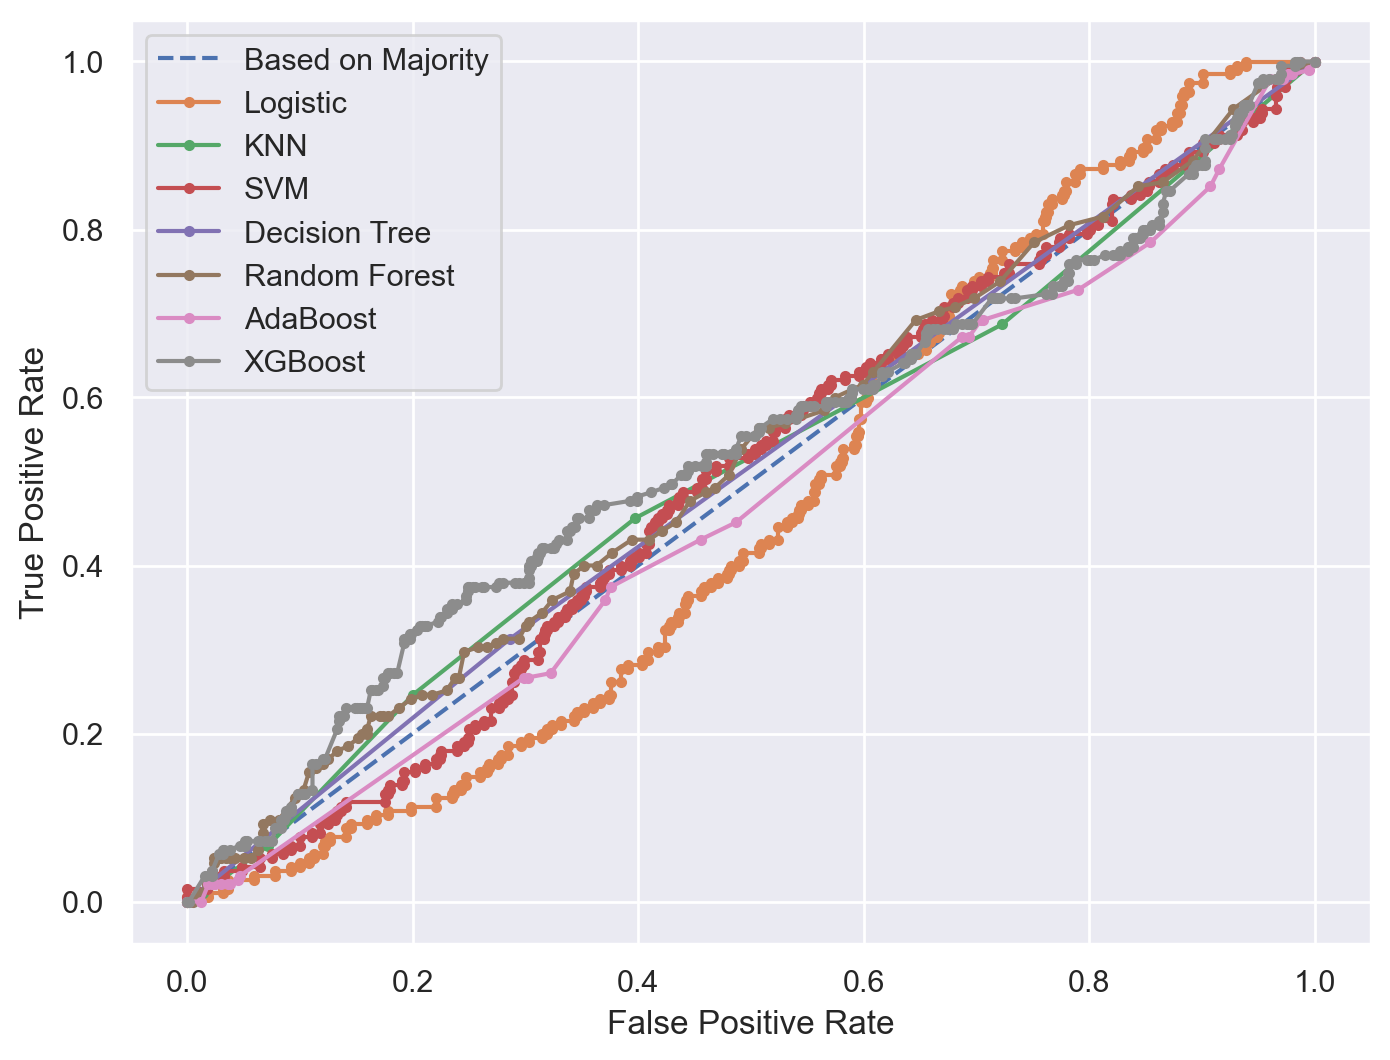

In [82]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lm_fpr, lm_tpr, _ = roc_curve(y_test, prob_lm)
knn_fpr, knn_tpr, _ = roc_curve(y_test, prob_knn)
svc_fpr, svc_tpr, _ = roc_curve(y_test, prob_svc)
tree_fpr, tree_tpr, _ = roc_curve(y_test, prob_tree)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, prob_rfc)
adb_fpr, adb_tpr, _ = roc_curve(y_test, prob_adb)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Based on Majority')
plt.plot(lm_fpr, lm_tpr, marker='.', label='Logistic')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVM')
plt.plot(tree_fpr, tree_tpr, marker='.', label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')
plt.plot(adb_fpr, adb_tpr, marker='.', label='AdaBoost')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()